In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import tensorflow.compat.v1.logging as logging
import pprint
from sklearn.metrics import roc_curve, auc, roc_auc_score    

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
class PQ(object):
    """Pure python implementation of Product Quantization (PQ) [Jegou11]_.
    For the indexing phase of database vectors,
    a `D`-dim input vector is divided into `M` `D`/`M`-dim sub-vectors.
    Each sub-vector is quantized into a small integer via `Ks` codewords.
    For the querying phase, given a new `D`-dim query vector, the distance beween the query
    and the database PQ-codes are efficiently approximated via Asymmetric Distance.
    All vectors must be np.ndarray with np.float32
    .. [Jegou11] H. Jegou et al., "Product Quantization for Nearest Neighbor Search", IEEE TPAMI 2011
    Args:
        M (int): The number of sub-space
        Ks (int): The number of codewords for each subspace
            (typically 256, so that each sub-vector is quantized
            into 256 bits = 1 byte = uint8)
        verbose (bool): Verbose flag
    Attributes:
        M (int): The number of sub-space
        Ks (int): The number of codewords for each subspace
        verbose (bool): Verbose flag
        code_dtype (object): dtype of PQ-code. Either np.uint{8, 16, 32}
        codewords (np.ndarray): shape=(M, Ks, Ds) with dtype=np.float32.
            codewords[m][ks] means ks-th codeword (Ds-dim) for m-th subspace
        Ds (int): The dim of each sub-vector, i.e., Ds=D/M
    """
    def __init__(self, codewords, M=8, Ks=256, verbose=True):
        assert 0 < Ks <= 2 ** 32
        self.M, self.Ks, self.verbose = M, Ks, verbose
        self.code_dtype = np.uint8 if Ks <= 2 ** 8 else (np.uint16 if Ks <= 2 ** 16 else np.uint32)
        self.codewords = codewords
        self.Ds = self.codewords.shape[2]

#         if verbose:
#             print("M: {}, Ks: {}, code_dtype: {}".format(M, Ks, self.code_dtype))

    def __eq__(self, other):
        if isinstance(other, PQ):
            return (self.M, self.Ks, self.verbose, self.code_dtype, self.Ds) == \
                   (other.M, other.Ks, other.verbose, other.code_dtype, other.Ds) and \
                   np.array_equal(self.codewords, other.codewords)
        else:
            return False

    def fit(self, vecs, iter=20, seed=123):
        """Given training vectors, run k-means for each sub-space and create
        codewords for each sub-space.
        This function should be run once first of all.
        Args:
            vecs (np.ndarray): Training vectors with shape=(N, D) and dtype=np.float32.
            iter (int): The number of iteration for k-means
            seed (int): The seed for random process
        Returns:
            object: self
        """
        assert vecs.ndim == 2
        N, D = vecs.shape
        assert self.Ks < N, "the number of training vector should be more than Ks"
        assert D % self.M == 0, "input dimension must be dividable by M"
        self.Ds = int(D / self.M)

        np.random.seed(seed)

        self.codewords = np.zeros((self.M, self.Ks, self.Ds), dtype=np.float32)
        for m in range(self.M):

            vecs_sub = vecs[:, m * self.Ds : (m+1) * self.Ds]
            self.codewords[m], _ = kmeans2(vecs_sub, self.Ks, iter=iter, minit='points')

        return self

    def encode(self, vecs):
        """Encode input vectors into PQ-codes.
        Args:
            vecs (np.ndarray): Input vectors with shape=(N, D) and dtype=np.float32.
        Returns:
            np.ndarray: PQ codes with shape=(N, M) and dtype=self.code_dtype
        """
        assert vecs.ndim == 2
        N, D = vecs.shape
        assert D == self.Ds * self.M, "input dimension must be Ds * M"

        codes = np.empty((N, self.M), dtype=self.code_dtype) 
        for m in range(self.M):

            vecs_sub = vecs[:, m * self.Ds : (m+1) * self.Ds]
            codes[:, m], _ = vq(vecs_sub, self.codewords[m]) 

        return codes

    def decode(self, codes):
        """Given PQ-codes, reconstruct original D-dimensional vectors
        approximately by fetching the codewords.
        Args:
            codes (np.ndarray): PQ-cdoes with shape=(N, M) and dtype=self.code_dtype.
                Each row is a PQ-code
        Returns:
            np.ndarray: Reconstructed vectors with shape=(N, D) and dtype=np.float32
        """
        assert codes.ndim == 2
        N, M = codes.shape
        assert M == self.M

        vecs = np.empty((N, self.Ds * self.M))
        for m in range(self.M):
            vecs[:, m * self.Ds : (m+1) * self.Ds] = self.codewords[m][codes[:, m], :]
        return vecs
    
    def dtable(self, query):
        '''
            可能我需要进行返回并不是是最近的质点，而是要多个才行
        '''
        dtable = np.empty((self.M, self.Ks))
        result_cluster = np.empty((self.M, self.Ks))
        distance = 0
        for m in range(self.M):
            query_sub = query[m * self.Ds : (m+1) * self.Ds] 
            dtable[m, :] = np.linalg.norm(self.codewords[m] - query_sub, axis=1)
            result_cluster[m] = np.sort(dtable[m])  
            distance += result_cluster[m][0] 
        return distance

加载Cifar数据集

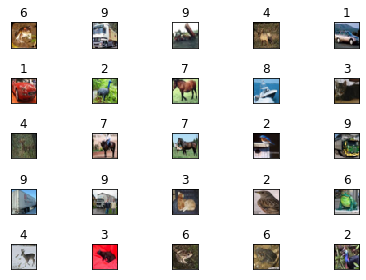

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

train_x = []
train_y = []
# 读取训练数据集
for i in range(5):
    file = "./dataSet/data_batch_%d"%(i+1)
    dicts = unpickle(file)
    labels = dicts[b'labels']
    data = dicts[b'data'].reshape(-1, 3, 32, 32) # 3*32x32
    data = data.transpose(0,2,3,1)

    for j in range(len(labels)):
        img_data = data[j]
        label = labels[j]
        train_x.append(img_data)
        train_y.append(label)
# 读取测试数据集
test_x = []
test_y = []
for i in range(1):
    # file = "./data_batch_%d"%(i+1)
    file = "./dataSet/test_batch"
    dicts = unpickle(file)
    labels = dicts[b'labels']
    data = dicts[b'data'].reshape(-1, 3, 32, 32) # 3*32x32
    data = data.transpose(0,2,3,1)

    for j in range(len(labels)):
        img_data = data[j]
        label = labels[j]
        test_x.append(img_data)
        test_y.append(label)
# 画图函数
def matplotMnist(x_train, y_train):
    fig, ax = plt.subplots(nrows=5, ncols=5, sharex='all', sharey='all')
    ax = ax.flatten()
    for i in range(25):
        img = x_train[i].reshape(32, 32, 3)
        ax[i].set_title(y_train[i])
        ax[i].imshow(img)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
matplotMnist(train_x, train_y)

In [4]:
train_x = np.array(train_x)
train_y = np.array(train_y).reshape(1, -1)
test_x = np.array(test_x)
test_y = np.array(test_y).reshape(1, -1)

数据集处理结束

推理过程：<br>
    &nbsp;&nbsp;&nbsp;&nbsp;<1>测试数据经过特征提取器F，获得特征<br>
    &nbsp;&nbsp;&nbsp;&nbsp;<2>计算与PQ Table C 的距离<br>
    &nbsp;&nbsp;&nbsp;&nbsp;<3>设定阈值ts，if <= ts ? True : False 

In [5]:
import time
import sys
import pickle
# 计算🉐分
def AU_ROC_SCORE(distance_arr, true_y):
    from sklearn.metrics import roc_auc_score
    roc_auc_scores = []
    for threshold in np.arange(int(np.min(distance_arr)), int(np.max(distance_arr)), 0.1):
        y_predict = np.array(distance_arr <= threshold, dtype='int')
        y_predict = y_predict.reshape((-1, 1))
        true_y = true_y.reshape((-1, 1))
        roc_auc_scores.append(roc_auc_score(true_y, y_predict))
    print("AU_ROC_SCORE is {:.2f}".format(np.max(roc_auc_scores)))
# 实现我们的TP
def TP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 1))
def FN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 0))
def FP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 0) & (y_predict == 1))
def TN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 0) & (y_predict == 0))
def TPR(y_true, y_predict):
    return TP(y_true, y_predict) / (TP(y_true, y_predict) + FN(y_true, y_predict))
def FPR(y_true, y_predict):
    return FP(y_true, y_predict) / (FP(y_true, y_predict) + TN(y_true, y_predict))
def ROC(distance_arr, true_y):
    fprs = []
    tprs = []
    for threshold in np.arange(int(np.min(distance_arr)), int(np.max(distance_arr)), 0.01):
        y_predict = np.array(distance_arr <= threshold, dtype='int') # 小于这个阈值，我们预测为正常值
        true_y = true_y.reshape((1, -1))
        y_predict = y_predict.reshape((1, -1))
        fprs.append(FPR(true_y, y_predict))
        tprs.append(TPR(true_y, y_predict))
    plt.plot(fprs, tprs)
    plt.title("Cifar10") 
    plt.xlabel("threshold") 
    plt.ylabel("ROC")
    plt.ylim(0, 1)
    plt.xlim(0, 1)



if __name__=="__main__":
    
    for norm_label in range(10):
        print("==================== 正常样本的label为第 %d 类 ================="%(norm_label+1))
        # 实例化PQ, C 是PQ Table, M 是子空间数量， Ks 是聚类数量
        PQTable_filename = './PQTable/C_%d.txt'%(norm_label)
        f=open(PQTable_filename, 'rb')  
        C = pickle.load(f) 
        f.close()
        pprint.pprint("PQ Table C 加载完毕～～～")
        Ks = 16
        M = 4
        logging.info("保留的维度为 = 32")
        logging.info("聚类的数目Ks = 16")
        logging.info("子空间数量M = 4")
        pq = PQ(codewords=C, M=M, Ks=Ks)
        # 加载模型
        model_path = './models/model_path_%d'%norm_label
        model = tf.saved_model.load(model_path)
        infer = model.signatures['serving_default']
        logging.info("模型加载结束～～～～")
        distance_list = []
        # 可以看到我们这边使用的是 for 循环，没有用到矩阵运算
        # 但是这并不妨碍， 我们算法的效率
        start_time = time.time()
        logging.info("正在进行异常检测阶段 ...")
        for i in range(test_x.shape[0]):
            test_x_ = test_x[i]
            test_x_ = tf.expand_dims(tf.cast(test_x_, tf.float32), axis=0)
            test_x_ = infer(test_x_)
            test_x_ = test_x_['output_0'].numpy()
            distance = pq.dtable(test_x_[0]) # 得到我们查询点到各个质点距离的倒序，返回的是距离
            distance_list.append(distance)  
        print("平均消耗的时间(ms)为", ((time.time()-start_time) / test_x.shape[0]) * 1000)
        distance_arr = np.array(distance_list)
        distance_arr = distance_arr.reshape((1, -1))
        # 进行最大归一化
        distance_arr /= np.max(distance_arr)
        # 复制一份出来
        # 复制一份出来
        true_y = test_y.copy()
        true_y[test_y == norm_label] = 0
        true_y[test_y != norm_label] = 1
        fpr, tpr, tresholds = roc_curve(true_y.flatten(), distance_arr.flatten())
        print("AUROC is :", auc(fpr, tpr))

==================== 正常样本的label为第 1 类 =================
'PQ Table C 加载完毕～～～'
INFO:tensorflow:保留的维度为 = 32
INFO:tensorflow:聚类的数目Ks = 16
INFO:tensorflow:子空间数量M = 4
INFO:tensorflow:模型加载结束～～～～
INFO:tensorflow:正在进行异常检测阶段 ...
平均消耗的时间(ms)为 1.3332622289657594
AUROC is : 0.7710817777777778
==================== 正常样本的label为第 2 类 =================
'PQ Table C 加载完毕～～～'
INFO:tensorflow:保留的维度为 = 32
INFO:tensorflow:聚类的数目Ks = 16
INFO:tensorflow:子空间数量M = 4
INFO:tensorflow:模型加载结束～～～～
INFO:tensorflow:正在进行异常检测阶段 ...
平均消耗的时间(ms)为 1.1154179096221923
AUROC is : 0.7786153333333334
==================== 正常样本的label为第 3 类 =================
'PQ Table C 加载完毕～～～'
INFO:tensorflow:保留的维度为 = 32
INFO:tensorflow:聚类的数目Ks = 16
INFO:tensorflow:子空间数量M = 4
INFO:tensorflow:模型加载结束～～～～
INFO:tensorflow:正在进行异常检测阶段 ...
平均消耗的时间(ms)为 1.1965672969818115
AUROC is : 0.6893744444444444
==================== 正常样本的label为第 4 类 =================
'PQ Table C 加载完毕～～～'
INFO:tensorflow:保留的维度为 = 32
INFO:tensorflow:聚类的数目Ks = 16
INFO:tensorflow:子空间数量M 